# Topic: Customer Clustering with RFM 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime

Data understanding

In [3]:
products = pd.read_csv('Data/Products_with_Categories.csv')
transactions = pd.read_csv('Data/Transactions.csv')

In [4]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    167 non-null    int64  
 1   productName  167 non-null    object 
 2   price        167 non-null    float64
 3   Category     167 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 5.3+ KB


In [5]:
products.head(5)

,productId,productName,price,Category
0,1,tropical fruit,7.8,Fresh Food
1,2,whole milk,1.8,Dairy
2,3,pip fruit,3.0,Fresh Food
3,4,other vegetables,0.8,Fresh Food
4,5,rolls/buns,1.2,Bakery & Sweets


In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Member_number  38765 non-null  int64 
 1   Date           38765 non-null  object
 2   productId      38765 non-null  int64 
 3   items          38765 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ MB


In [7]:
transactions.head(5)

,Member_number,Date,productId,items
0,1808,21-07-2015,1,3
1,2552,05-01-2015,2,1
2,2300,19-09-2015,3,3
3,1187,12-12-2015,4,3
4,3037,01-02-2015,2,1


Data Pre-processing

In [8]:
string_to_date = lambda x : datetime.strptime(x, "%d-%m-%Y").date()
transactions['Date'] = transactions['Date'].apply(string_to_date)
transactions['Date'] = transactions['Date'].astype('datetime64[ns]')

In [9]:
transactions.isnull().sum()

Member_number    0
Date             0
productId        0
items            0
dtype: int64

In [10]:
products.isnull().sum()

productId      0
productName    0
price          0
Category       0
dtype: int64

In [11]:
transactions.isna().sum()

Member_number    0
Date             0
productId        0
items            0
dtype: int64

In [12]:
products.isna().sum()

productId      0
productName    0
price          0
Category       0
dtype: int64

In [13]:
df = transactions.merge(products, on='productId', how='left')

In [14]:
df.head(5)

,Member_number,Date,productId,items,productName,price,Category
0,1808,2015-07-21,1,3,tropical fruit,7.8,Fresh Food
1,2552,2015-01-05,2,1,whole milk,1.8,Dairy
2,2300,2015-09-19,3,3,pip fruit,3.0,Fresh Food
3,1187,2015-12-12,4,3,other vegetables,0.8,Fresh Food
4,3037,2015-02-01,2,1,whole milk,1.8,Dairy


In [15]:
df['total_sales'] = df['items'] * df['price']

In [16]:
df['transaction_id'] = range(1,len(df)+1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38765 entries, 0 to 38764
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Member_number   38765 non-null  int64         
 1   Date            38765 non-null  datetime64[ns]
 2   productId       38765 non-null  int64         
 3   items           38765 non-null  int64         
 4   productName     38765 non-null  object        
 5   price           38765 non-null  float64       
 6   Category        38765 non-null  object        
 7   total_sales     38765 non-null  float64       
 8   transaction_id  38765 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 3.0+ MB


In [18]:
df.isnull().sum()

Member_number     0
Date              0
productId         0
items             0
productName       0
price             0
Category          0
total_sales       0
transaction_id    0
dtype: int64

In [32]:
df.isna().any()

Member_number     False
Date              False
productId         False
items             False
productName       False
price             False
Category          False
total_sales       False
transaction_id    False
dtype: bool

In [19]:
print('{:,} unique member_number'.format(transactions['Member_number'].nunique()))
print('Transactions timeframe from {} to {}'.format(transactions['Date'].min(), transactions['Date'].max()))

3,898 unique member_number
Transactions timeframe from 2014-01-01 00:00:00 to 2015-12-30 00:00:00


In [ ]:
df.where(df['price']<0).any()

In [ ]:
df.where(df['items']<=0).any()

RFM

In [22]:
max_date = df['Date'].max().date()

Recency = Recency = lambda x : (max_date - x.max().date()).days
Frequency  = lambda x: len(x.unique())
Monetary = lambda x: sum(x)

df_RFM = df.groupby('Member_number').agg({'Date':Recency,
                                          'transaction_id': Frequency,
                                          'total_sales':Monetary})


In [23]:
df_RFM.head()

,Date,transaction_id,total_sales
Member_number,,,
1000,35,13,53.80
1001,242,12,100.00
1002,122,8,70.30
1003,323,8,60.65
1004,28,21,204.96


In [24]:
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']

In [33]:
df_RFM.head()

,Recency,Frequency,Monetary
Member_number,,,
1000,35,13,53.80
1001,242,12,100.00
1002,122,8,70.30
1003,323,8,60.65
1004,28,21,204.96


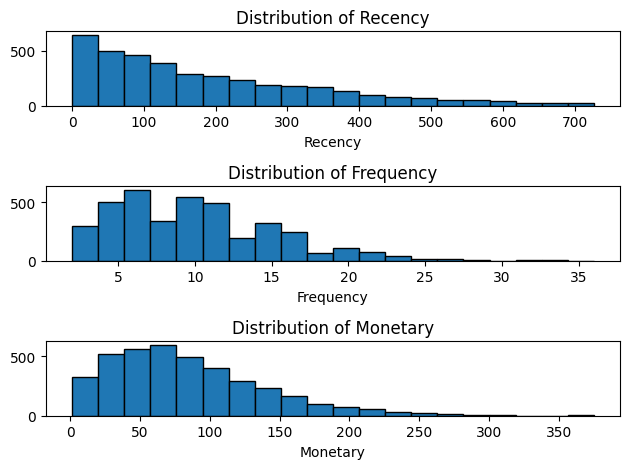

In [25]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(df_RFM['Recency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.hist(df_RFM['Frequency'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.hist(df_RFM['Monetary'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

Cả 3 Recency, Frequency and Monetary đều right skew và không phải normal distribution --> Log transfomation để giảm skewness

In [26]:
df_log_transformed = df_RFM.apply(lambda x: np.log1p(x) if x.name in ['Recency', 'Frequency', 'Monetary'] else x)

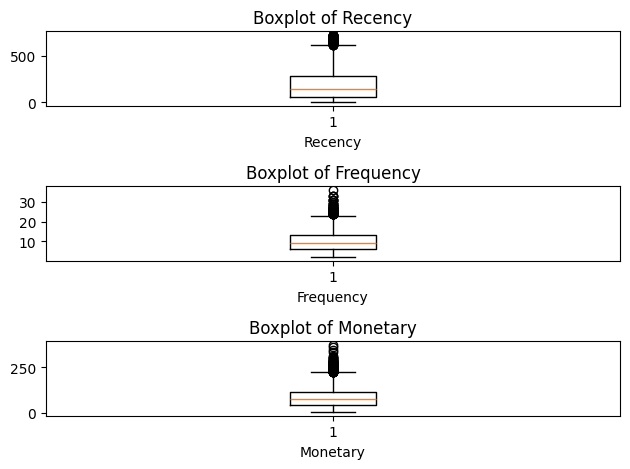

In [27]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.boxplot(df_RFM['Recency']) # Chọn số lượng bins phù hợp
plt.title('Boxplot of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.boxplot(df_RFM['Frequency']) # Chọn số lượng bins phù hợp
plt.title('Boxplot of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.boxplot(df_RFM['Monetary']) # Chọn số lượng bins phù hợp
plt.title('Boxplot of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

Cả 3 Recency, Frequency and Monetary đều có nhiều upper outliers --> Robust Scaler để giảm ảnh hưởng của outliers

In [28]:
from sklearn.preprocessing import RobustScaler
robust = RobustScaler()
df_scaled = pd.DataFrame(robust.fit_transform(df_log_transformed[['Recency', 'Frequency', 'Monetary']]), 
                         columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], 
                         index=df_RFM.index)

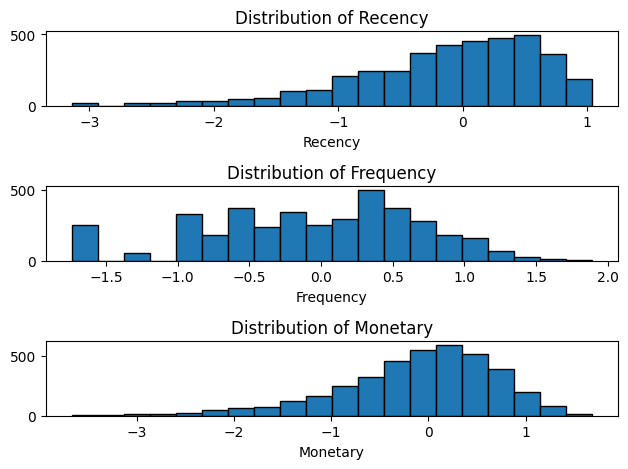

In [29]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.hist(df_scaled['Recency_scaled'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.hist(df_scaled['Frequency_scaled'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.hist(df_scaled['Monetary_scaled'], bins=20, edgecolor='black') # Chọn số lượng bins phù hợp
plt.title('Distribution of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

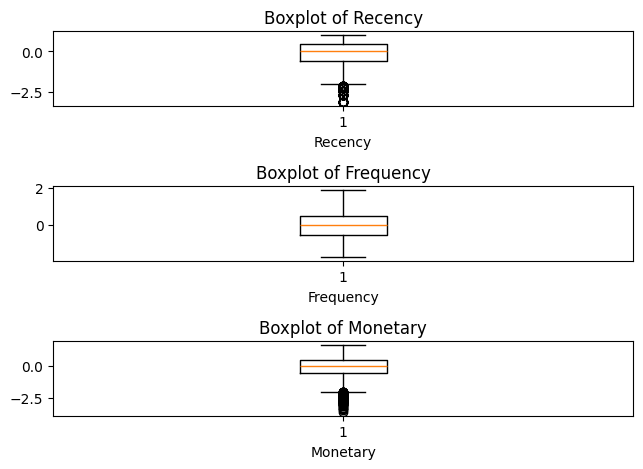

In [30]:
# Vẽ phân phối của 'Recency'
plt.subplot(3, 1, 1) # 3 hàng, 1 cột, vị trí thứ nhất
plt.boxplot(df_scaled['Recency_scaled']) # Chọn số lượng bins phù hợp
plt.title('Boxplot of Recency')
plt.xlabel('Recency')

# Vẽ phân phối của 'Frequency'
plt.subplot(3, 1, 2) # 3 hàng, 1 cột, vị trí thứ hai
plt.boxplot(df_scaled['Frequency_scaled']) # Chọn số lượng bins phù hợp
plt.title('Boxplot of Frequency')
plt.xlabel('Frequency')

# Vẽ phân phối của 'Monetary'
plt.subplot(3, 1, 3) # 3 hàng, 1 cột, vị trí thứ ba
plt.boxplot(df_scaled['Monetary_scaled']) # Chọn số lượng bins phù hợp
plt.title('Boxplot of Monetary')
plt.xlabel('Monetary')

plt.tight_layout()
plt.show()

In [31]:
df_scaled.head()

,Recency_scaled,Frequency_scaled,Monetary_scaled
Member_number,,,
1000,-0.869699,0.485427,-0.341540
1001,0.340472,0.378512,0.299574
1002,-0.091033,-0.152003,-0.065556
1003,0.522790,-0.152003,-0.218039
1004,-1.006730,1.137504,1.046730
